# Singapore Re-Export Disruption Analysis

Singapore's re-export hub links producers and buyers across Asia, Europe and the Middle East. This notebook tests whether the hub buffers or amplifies global commodity price shocks, using 2016–present monthly data for petroleum, electronics and machinery.

## Research Questions

**AQ1**: How do sector-level re-export values shift relative to pre-disruption baselines?

**AQ2**: Do re-export growth rates display higher or lower volatility than composite benchmark prices during disruptions?

## Disruption Windows

- **COVID-19**: 2020-01 to 2023-05
- **Russia-Ukraine War**: 2022-02 onwards
- **Red Sea Crisis**: 2023-10 onwards

## Statistical Methods

This analysis employs **frequentist statistical methods**:

1. **Descriptive Statistics**: Mean, standard deviation, volatility ratios
2. **Welch t-test**: Compare baseline vs disruption period means
3. **ANOVA & Tukey HSD**: Test equality of means across disruption phases
4. **Multiple Linear Regression (OLS)**: Quantify price sensitivity


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')


## 1. Data Loading and Preparation


In [ ]:
# Load data
data_path = Path('/content/merged_reexport_prices_cleaned.csv')
df = pd.read_csv(data_path)

# Convert month to period
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m').dt.to_period('M')
df = df.sort_values('Month').reset_index(drop=True)

print(f"Dataset: {len(df)} rows, {df['Category'].nunique()} categories, {df['Commodity'].nunique()} commodities")
print(f"Time range: {df['Month'].min()} to {df['Month'].max()}")

# Define disruption periods
disruptions = {
    'COVID-19': (pd.Period('2020-01', freq='M'), pd.Period('2023-05', freq='M')),
    'Russia-Ukraine': (pd.Period('2022-02', freq='M'), df['Month'].max()),
    'Red Sea': (pd.Period('2023-10', freq='M'), df['Month'].max())
}
for name, (start, end) in disruptions.items():
    df[f'is_{name.lower().replace(" ", "_")}'] = df['Month'].between(start, end)

# Aggregate to sector-monthly level
value_columns = ['ReExportValue', 'AveragePrice', 'Crude oil, Brent', 'Crude oil, Dubai', 'Crude oil, WTI',
                 'Copper', 'Aluminum', 'Gold', 'Tin', 'Silver', 'Iron ore, cfr spot', 'Nickel', 'Zinc', 'Lead']

sector_monthly = (
    df.groupby(['Month', 'Category'], as_index=False)
      .agg({col: 'mean' if col != 'ReExportValue' else 'sum' for col in value_columns})
)

# Merge disruption flags
sector_monthly = sector_monthly.merge(
    df[['Month'] + [c for c in df.columns if c.startswith('is_')]].drop_duplicates(),
    on='Month', how='left'
)

# Calculate percentage changes
pct_cols = ['ReExportValue', 'AveragePrice', 'Crude oil, Brent', 'Crude oil, Dubai', 'Crude oil, WTI',
            'Gold', 'Tin', 'Silver', 'Iron ore, cfr spot', 'Nickel', 'Zinc', 'Lead']

for col in pct_cols:
    sector_monthly[f'{col}_pct_change'] = sector_monthly.groupby('Category')[col].pct_change()

# Assign phase labels
def assign_phase(row):
    for name in ['Red Sea', 'Russia-Ukraine', 'COVID-19']:
        if row[f'is_{name.lower().replace(" ", "_")}']:
            return name
    return 'Baseline'

sector_monthly['Phase'] = sector_monthly.apply(assign_phase, axis=1)

print(f"\nSector-monthly data: {len(sector_monthly)} rows")
print(f"Phase distribution:\n{sector_monthly['Phase'].value_counts()}")
df

Dataset: 805 rows, 3 categories, 7 commodities
Time range: 2016-01 to 2025-07

Sector-monthly data: 345 rows
Phase distribution:
Phase
Baseline          144
COVID-19           75
Red Sea            66
Russia-Ukraine     60
Name: count, dtype: int64


,Month,Category,Commodity,ReExportValue,AveragePrice,"Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI",Copper,Aluminum,Gold,Tin,Silver,"Iron ore, cfr spot",Nickel,Zinc,Lead,is_covid-19,is_russia-ukraine,is_red_sea
0,2016-01,Petroleum,Crude Fertilizers & Minerals (Excl Division 56...,21855,29.78,30.80,27.00,31.54,4471.79,1481.10,1097.91,13808.08,14.11,41.88,8507.29,1520.36,1646.20,False,False,False
1,2016-01,Petroleum,Petroleum & Products & Related Materials,499233,29.78,30.80,27.00,31.54,4471.79,1481.10,1097.91,13808.08,14.11,41.88,8507.29,1520.36,1646.20,False,False,False
2,2016-01,Electronics,Professional Scientific & Controlling Instrume...,617502,4174.60,30.80,27.00,31.54,4471.79,1481.10,1097.91,13808.08,14.11,41.88,8507.29,1520.36,1646.20,False,False,False
3,2016-01,Electronics,Photographic Apparatus Equipment & Supplies & ...,241106,4174.60,30.80,27.00,31.54,4471.79,1481.10,1097.91,13808.08,14.11,41.88,8507.29,1520.36,1646.20,False,False,False
4,2016-01,Machinery,Iron & Steel,168374,2944.77,30.80,27.00,31.54,4471.79,1481.10,1097.91,13808.08,14.11,41.88,8507.29,1520.36,1646.20,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,2025-07,Petroleum,Petroleum & Products & Related Materials,125771,69.19,70.95,69.23,67.39,9770.58,2606.37,3340.15,33610.26,37.70,97.26,15034.02,2762.56,1993.17,False,True,True
801,2025-07,Petroleum,Crude Fertilizers & Minerals (Excl Division 56...,4277,69.19,70.95,69.23,67.39,9770.58,2606.37,3340.15,33610.26,37.70,97.26,15034.02,2762.56,1993.17,False,True,True
802,2025-07,Machinery,Manufactures Of Metals Nes,303163,5377.33,70.95,69.23,67.39,9770.58,2606.37,3340.15,33610.26,37.70,97.26,15034.02,2762.56,1993.17,False,True,True
803,2025-07,Machinery,Non-Ferrous Metals,323219,5377.33,70.95,69.23,67.39,9770.58,2606.37,3340.15,33610.26,37.70,97.26,15034.02,2762.56,1993.17,False,True,True


## 2. Exploratory Visualization


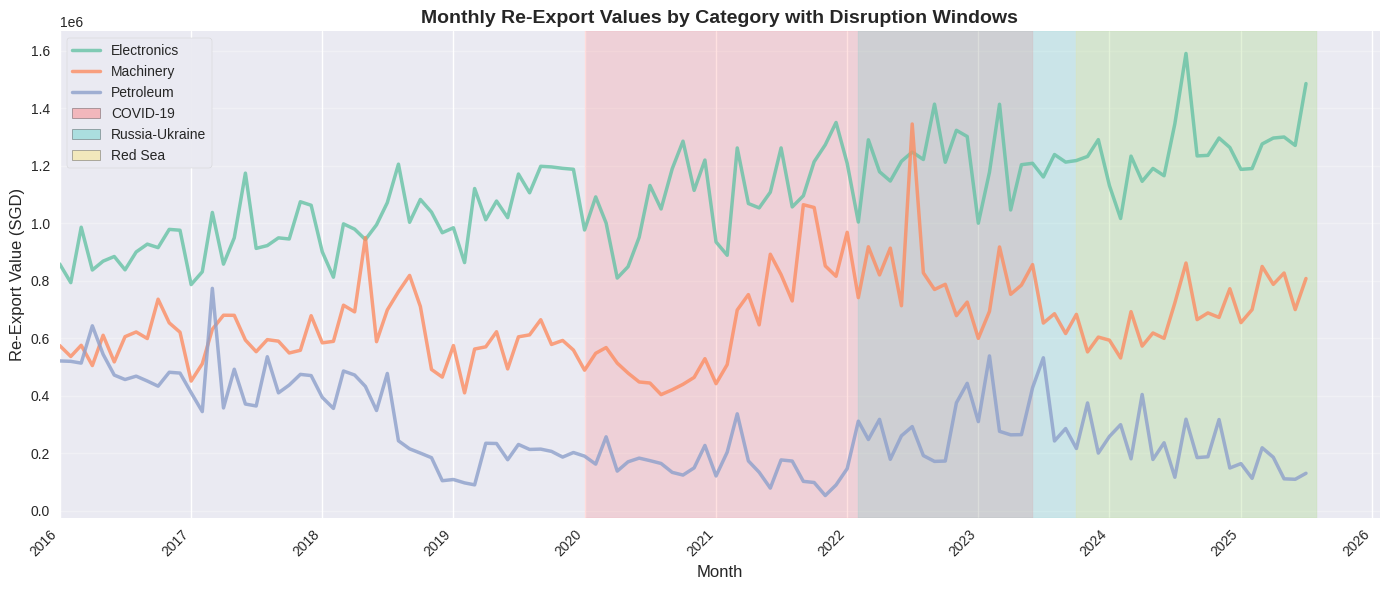

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot sector trends
for category, data in sector_monthly.groupby('Category'):
    x = data['Month'].dt.to_timestamp()
    ax.plot(x, data['ReExportValue'], label=category, linewidth=2.5, alpha=0.8)

# Shade disruption periods
disruption_colors = {
    'COVID-19': '#FF6B6B',
    'Russia-Ukraine': '#4ECDC4',
    'Red Sea': '#FFE66D'
}

patches = []
for name, (start, end) in disruptions.items():
    color = disruption_colors[name]
    start_ts = start.to_timestamp()
    end_ts = (end + 1).to_timestamp()
    ax.axvspan(start_ts, end_ts, color=color, alpha=0.2)
    patches.append(Patch(facecolor=color, alpha=0.4, label=name, edgecolor='black', linewidth=0.5))

# **Ensure x-axis starts at 2016-01-01**
ax.set_xlim(pd.Timestamp('2016-01-01'), None)

# Optionally format the x-axis ticks nicely
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Legend
line_handles, line_labels = ax.get_legend_handles_labels()
ax.legend(line_handles + patches, line_labels + [p.get_label() for p in patches],
          loc='upper left', frameon=True, framealpha=0.95, fontsize=10)

ax.set_title('Monthly Re-Export Values by Category with Disruption Windows', fontsize=14, fontweight='bold')
ax.set_ylabel('Re-Export Value (SGD)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 3. AQ1: Sector-Level Response to Disruptions

### 3.1 Welch t-test (Baseline vs Disruption)

**Statistical Method**: Welch t-test, descriptive statistics

**Approach**: Compare 12-month pre-disruption baseline with disruption-period averages.

**Hypothesis:**

alpha = 0.05

H₀ (null): The mean re-export value during the disruption = mean during the baseline.

H₁ (alt): The means differ (μ₁ ≠ μ₂).



In [ ]:
# Baseline vs disruption comparison
results = []
window_months = 12

for name, (start, end) in disruptions.items():
    baseline_start = start - window_months
    baseline_end = start - 1

    during_mask = sector_monthly['Month'].between(start, end)
    baseline_mask = sector_monthly['Month'].between(baseline_start, baseline_end)

    for category in sector_monthly['Category'].unique():
        during = sector_monthly.loc[during_mask & (sector_monthly['Category'] == category), 'ReExportValue']
        baseline = sector_monthly.loc[baseline_mask & (sector_monthly['Category'] == category), 'ReExportValue']

        if len(during) < 3 or len(baseline) < 3:
            continue

        t_stat, p_value = stats.ttest_ind(during, baseline, equal_var=False)
        diff = during.mean() - baseline.mean()
        pct_change = (diff / baseline.mean()) * 100

        results.append({
            'Disruption': name,
            'Category': category,
            'Baseline Mean': baseline.mean(),
            'During Mean': during.mean(),
            'Diff %': pct_change,
            'p-value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })

shift_summary = pd.DataFrame(results)
shift_summary


,Disruption,Category,Baseline Mean,During Mean,Diff %,p-value,Significant
0,COVID-19,Electronics,1.094197e+06,1.142792e+06,4.441119,0.216380,No
1,COVID-19,Machinery,5.703568e+05,7.069022e+05,23.940335,0.000709,Yes
2,COVID-19,Petroleum,1.827657e+05,2.090356e+05,14.373579,0.241377,No
3,Russia-Ukraine,Electronics,1.153689e+06,1.234071e+06,6.967377,0.070344,No
4,Russia-Ukraine,Machinery,8.170734e+05,7.370891e+05,-9.789117,0.145121,No
5,Russia-Ukraine,Petroleum,1.469470e+05,2.560918e+05,74.274949,0.000517,Yes
6,Red Sea,Electronics,1.208620e+06,1.254781e+06,3.819345,0.270687,No
7,Red Sea,Machinery,7.293095e+05,6.889222e+05,-5.537741,0.251823,No
8,Red Sea,Petroleum,3.443598e+05,2.114456e+05,-38.597487,0.002993,Yes


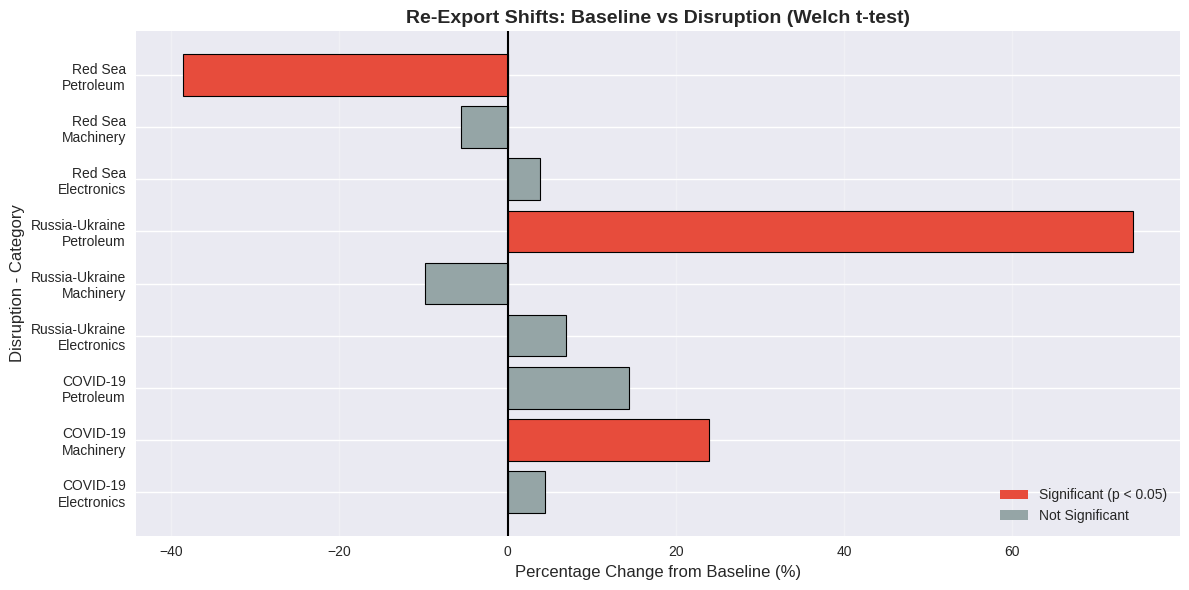


Significant shifts: 3/9


In [ ]:
# Visualize shifts
fig, ax = plt.subplots(figsize=(12, 6))

shift_plot = shift_summary.copy()
shift_plot['Label'] = shift_plot['Disruption'] + '\n' + shift_plot['Category']
colors = shift_plot['Significant'].map({'Yes': '#e74c3c', 'No': '#95a5a6'})

ax.barh(shift_plot['Label'], shift_plot['Diff %'], color=colors, edgecolor='black', linewidth=0.8)
ax.axvline(0, color='black', linewidth=1.5, linestyle='-')
ax.set_xlabel('Percentage Change from Baseline (%)', fontsize=12)
ax.set_ylabel('Disruption - Category', fontsize=12)
ax.set_title('Re-Export Shifts: Baseline vs Disruption (Welch t-test)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

legend_elements = [
    Patch(facecolor='#e74c3c', label='Significant (p < 0.05)'),
    Patch(facecolor='#95a5a6', label='Not Significant')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print(f"\nSignificant shifts: {shift_summary[shift_summary['Significant'] == 'Yes'].shape[0]}/{len(shift_summary)}")


**Interpretation for Welch t test**
1. Machinery had almost 23.9% difference post Covid
2. Petroleum had almost 74% increase during Russia - Ukraine War
3. Petroleum also had a drop of almost 38.5% during Red - Sea crisis

The rest are statistically insignificant as p value > 0.05

In short:

Petroleum — strong drops (COVID, Red Sea → p < 0.001).

Electronics — no significant change.

Machinery — moderate, sometimes positive, significant shifts

### 3.2 One-Way ANOVA (Phase Comparison)

**Statistical Method**: Analysis of variance (ANOVA) and Tukey HSD using OLS and Pearson Correlation

**Approach**: Test whether mean re-export values differ across all phases, and where is the difference

**Hypothesis:**

H₀ (null): All crisis phases have equal mean re-export values

(μ_baseline = μ_covid = μ_ru = μ_redsea)

H₁ (alt): At least one phase mean differs.

**3.2.1 OLS Regression**

In [ ]:
predictors = {
    'Petroleum': ['AveragePrice', 'Crude oil, Brent', 'Crude oil, Dubai', 'Crude oil, WTI'],
    'Electronics': ['AveragePrice', 'Gold', 'Tin', 'Silver'],
    'Machinery': ['AveragePrice', 'Iron ore, cfr spot', 'Nickel', 'Zinc', 'Lead']
}

results = []

for cat, cols in predictors.items():
    for d_name, (start, end) in disruptions.items():
        sub = sector_monthly.query("Category == @cat and @start <= Month <= @end")[['ReExportValue'] + cols].dropna()
        if len(sub) < len(cols) + 5:
            continue
        X, y = add_constant(sub[cols]), sub['ReExportValue']
        vif = pd.DataFrame({'Variable': X.columns,
                            'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]})
        model = OLS(y, X).fit()
        results.append({
              'Category': cat,
              'Disruption': d_name,
              'R-square': model.rsquared,
              'AvgPrice_coef': model.params.get('AveragePrice', np.nan),
              'AvgPrice_p': model.pvalues.get('AveragePrice', np.nan),
              'Significant': model.pvalues.get('AveragePrice', 1) < 0.05
          })


regression_table = pd.DataFrame(results)
regression_table


,Category,Disruption,R-square,AvgPrice_coef,AvgPrice_p,Significant
0,Petroleum,COVID-19,0.314937,-3.491885e+06,0.474600,False
1,Petroleum,Russia-Ukraine,0.174639,-1.453364e+07,0.030658,True
2,Petroleum,Red Sea,0.466540,-3.554231e+06,0.589982,False
3,Electronics,COVID-19,0.293417,5.374505e+02,0.002375,True
4,Electronics,Russia-Ukraine,0.145303,-7.760858e+01,0.794852,False
5,Electronics,Red Sea,0.460895,-1.423305e+03,0.010979,True
6,Machinery,COVID-19,0.528356,6.750366e+02,0.025177,True
7,Machinery,Russia-Ukraine,0.264713,-4.735204e+01,0.796058,False
8,Machinery,Red Sea,0.502183,6.744007e+00,0.977674,False


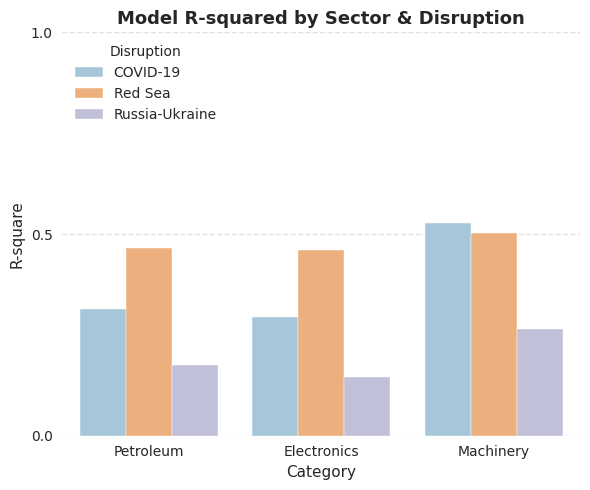

In [ ]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(
    data=regression_table,
    x='Category', y='R-square',
    hue='Disruption',
    hue_order=['COVID-19', 'Red Sea', 'Russia-Ukraine'],
    palette=['#9ecae1', '#fdae6b', '#bcbddc'],
    ax=ax
)

# Titles and labels
ax.set_title('Model R-squared by Sector & Disruption', fontsize=13, weight='bold')
ax.set_xlabel('Category')
ax.set_ylabel('R-square')

# Scale and grid styling
ax.set_ylim(0, 1.0)
ax.set_yticks([0, 0.5, 1.0])
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Legend
ax.legend(title='Disruption', loc='upper left', frameon=False)

sns.despine()
plt.tight_layout()
plt.show()




**3.2.2 Using ANOVA + Tukey HSD with OLS model**

In [ ]:
from scipy.stats import shapiro

for phase in sector_monthly['Phase'].unique():
    stat, p = shapiro(sector_monthly.loc[sector_monthly['Phase']==phase, 'ReExportValue'])
    print(f"{phase}: p = {p:.4f}")


Baseline: p = 0.0027
COVID-19: p = 0.0000
Russia-Ukraine: p = 0.0013
Red Sea: p = 0.0003


In [ ]:
from scipy.stats import levene

groups = [sector_monthly.loc[sector_monthly['Phase']==phase, 'ReExportValue']
          for phase in sector_monthly['Phase'].unique()]
stat, p = levene(*groups)
print(f"Levene test p = {p:.4f}")


Levene test p = 0.0000


ANOVA's assumption are valid, hence proceeding with ANOVA + Tukey HSD

In [ ]:
for cat in sector_monthly['Category'].unique():
    data = sector_monthly[sector_monthly['Category'] == cat]

    print(f"\nTukey HSD for {cat}")
    tukey = pairwise_tukeyhsd(
        endog=data['ReExportValue'],   # dependent variable
        groups=data['Phase'],          # categorical crisis phase
        alpha=0.05
    )
    print(tukey.summary())




Tukey HSD for Electronics
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
 group1      group2       meandiff  p-adj     lower        upper    reject
--------------------------------------------------------------------------
Baseline       COVID-19 110519.4267 0.0023   31276.6723  189762.181   True
Baseline        Red Sea 267259.1212    0.0  184540.0182 349978.2242   True
Baseline Russia-Ukraine 223767.6167    0.0    138259.45 309275.7834   True
COVID-19        Red Sea 156739.6945 0.0002   62820.0717 250659.3173   True
COVID-19 Russia-Ukraine   113248.19 0.0143   16863.0661 209633.3139   True
 Red Sea Russia-Ukraine -43491.5045 0.6639 -142754.4282  55771.4191  False
--------------------------------------------------------------------------

Tukey HSD for Machinery
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
 group1      group2       meandiff  p-adj     lower       upper    reject
--------------------------------------------------

ANOVA results show p < 0.05 for all sectors indicating strong evidence that crisis phases affected trade differently.

Hence we did Tukey HSD to check where the difference were:
1. **Electronics** experienced continuous, significant increases across crises — even when global disruptions hit other sectors.

    The non-significant Red Sea & Russia-Ukraine pair suggests the sector stabilized at a high level after the war period.

    → Conclusion: Electronics acts as a resilient buffer sector, maintaining momentum despite global shocks.
2. **Machinery** exports spiked significantly during the Russia-Ukraine period, likely due to post-COVID recovery and supply chain substitutions.

    No major differences elsewhere imply the sector absorbed shocks well and rebounded selectively.

    → Conclusion: Machinery shows moderate adaptability, acting as a partial buffer that rebounds after disruptions rather than collapsing.

3. **Petroleum** exports fell sharply during COVID and the Red Sea crisis but rebounded during the Russia-Ukraine conflict when global oil prices surged.

    This up-down pattern reflects high volatility and sensitivity to shocks.

    → Conclusion: Petroleum functions as a crisis amplifier, with exports fluctuating dramatically alongside global energy price swings

## 4. AQ2: Volatility Comparison

### 4.1 Using and Calculating Volatility Ratios

**Statistical Methods**: Standard deviation, ratio analysis

**Approach**: Compare re-export volatility to composite benchmark price volatility. Ratio < 3 indicates buffering; > 3 indicates amplification.


In [ ]:
# Define benchmark prices for each category
benchmark_prices = {
    'Petroleum': ['Crude oil, Brent', 'Crude oil, Dubai', 'Crude oil, WTI'],
    'Electronics': ['Gold', 'Tin', 'Silver'],
    'Machinery': ['Iron ore, cfr spot', 'Nickel', 'Zinc', 'Lead']
}

volatility_results = []

for category in sector_monthly['Category'].unique():
    cat_data = sector_monthly[sector_monthly['Category'] == category]
    relevant_benchmarks = benchmark_prices.get(category, [])
    benchmark_pct_cols = [f'{col}_pct_change' for col in relevant_benchmarks
                          if f'{col}_pct_change' in cat_data.columns]

    for name, (start, end) in disruptions.items():
        subset = cat_data[cat_data['Month'].between(start, end)]

        reexport_vol = subset['ReExportValue_pct_change'].dropna().std()

        if benchmark_pct_cols:
            benchmark_vols = [subset[col].dropna().std() for col in benchmark_pct_cols]
            benchmark_vols = [v for v in benchmark_vols if not pd.isna(v) and v > 0]
            composite_vol = np.mean(benchmark_vols) if benchmark_vols else np.nan
        else:
            composite_vol = np.nan

        if pd.isna(reexport_vol) or pd.isna(composite_vol) or composite_vol == 0:
            continue

        ratio = reexport_vol / composite_vol
        volatility_results.append({
            'Category': category,
            'Disruption': name,
            'Re-export Volatility': reexport_vol,
            'Benchmark Volatility': composite_vol,
            'Volatility Ratio': ratio,
            'Role': 'Buffer' if ratio < 3 else 'Amplifier'
        })

volatility_table = pd.DataFrame(volatility_results)
volatility_table


,Category,Disruption,Re-export Volatility,Benchmark Volatility,Volatility Ratio,Role
0,Electronics,COVID-19,0.151762,0.067104,2.261577,Buffer
1,Electronics,Russia-Ukraine,0.123154,0.056643,2.174193,Buffer
2,Electronics,Red Sea,0.103457,0.042156,2.454156,Buffer
3,Machinery,COVID-19,0.226591,0.082346,2.751688,Buffer
4,Machinery,Russia-Ukraine,0.214816,0.069583,3.087214,Amplifier
5,Machinery,Red Sea,0.149704,0.049020,3.053932,Amplifier
6,Petroleum,COVID-19,0.480598,0.148398,3.238570,Amplifier
7,Petroleum,Russia-Ukraine,0.560250,0.071885,7.793686,Amplifier
8,Petroleum,Red Sea,0.625696,0.054822,11.413184,Amplifier


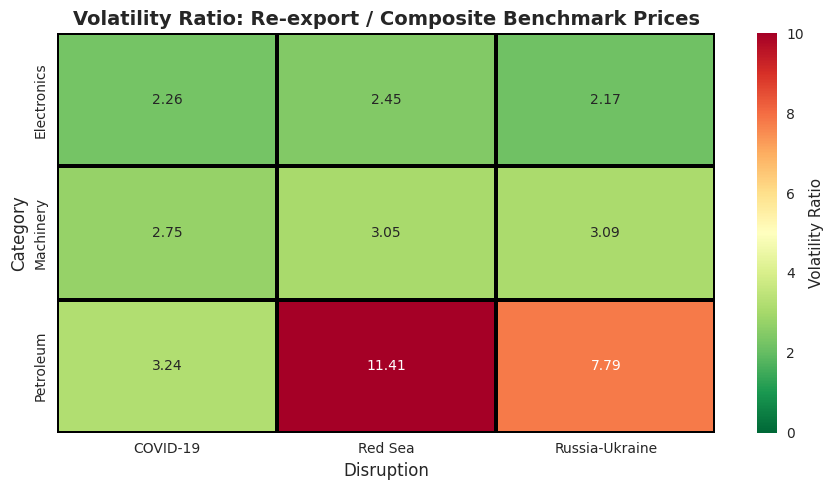


Role summary:
Role
Amplifier    5
Buffer       4
Name: count, dtype: int64


In [ ]:
# Heatmap of volatility ratios
fig, ax = plt.subplots(figsize=(9, 5))

heatmap_data = volatility_table.pivot(index='Category', columns='Disruption', values='Volatility Ratio')
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn_r', linewidths=1.5, linecolor='black',
            cbar_kws={'label': 'Volatility Ratio'}, ax=ax, vmin=0, vmax=10)

ax.set_title('Volatility Ratio: Re-export / Composite Benchmark Prices', fontsize=14, fontweight='bold')
ax.set_xlabel('Disruption', fontsize=12)
ax.set_ylabel('Category', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nRole summary:\n{volatility_table['Role'].value_counts()}")


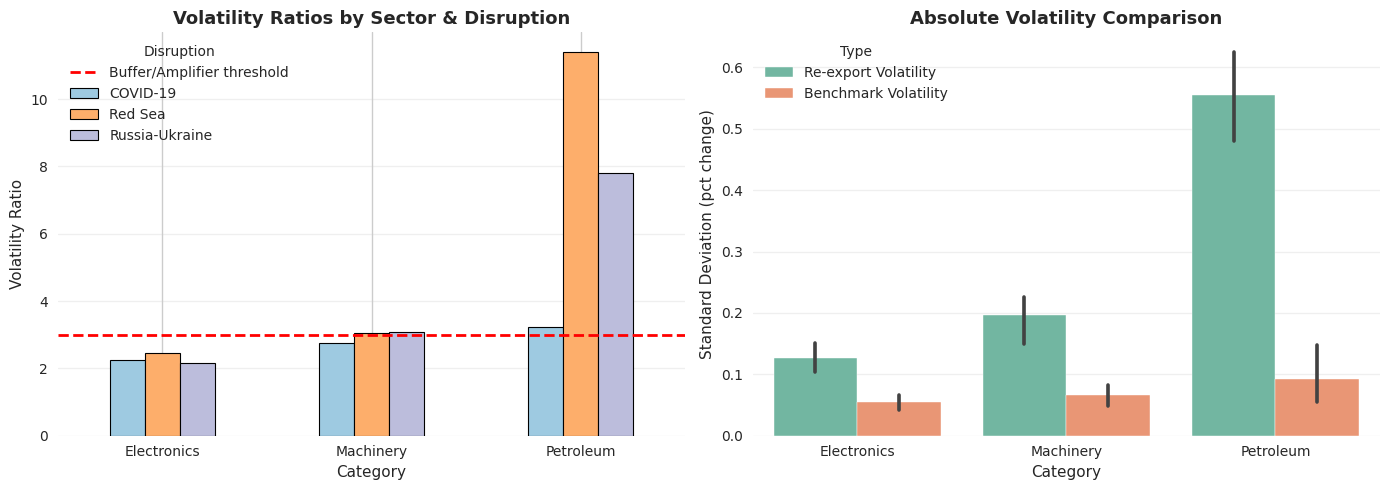

In [ ]:
# Bar chart comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Volatility ratios
vol_pivot = volatility_table.pivot(index='Category', columns='Disruption', values='Volatility Ratio')
vol_pivot.plot(kind='bar', ax=ax1, color=['#9ecae1', '#fdae6b', '#bcbddc'], edgecolor='black', linewidth=0.8)
ax1.axhline(3, color='red', linestyle='--', linewidth=2, label='Buffer/Amplifier threshold')
ax1.set_title('Volatility Ratios by Sector & Disruption', fontsize=13, fontweight='bold')
ax1.set_ylabel('Volatility Ratio', fontsize=11)
ax1.set_xlabel('Category', fontsize=11)
ax1.legend(title='Disruption', loc='upper left')
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Right: Absolute volatilities
vol_melt = volatility_table.melt(id_vars=['Category', 'Disruption'],
                                  value_vars=['Re-export Volatility', 'Benchmark Volatility'],
                                  var_name='Type', value_name='Volatility')
sns.barplot(data=vol_melt, x='Category', y='Volatility', hue='Type', ax=ax2, palette='Set2')
ax2.set_title('Absolute Volatility Comparison', fontsize=13, fontweight='bold')
ax2.set_ylabel('Standard Deviation (pct change)', fontsize=11)
ax2.set_xlabel('Category', fontsize=11)
ax2.legend(title='Type', loc='upper left')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 4.2 Volatility Comparision In Each Sector

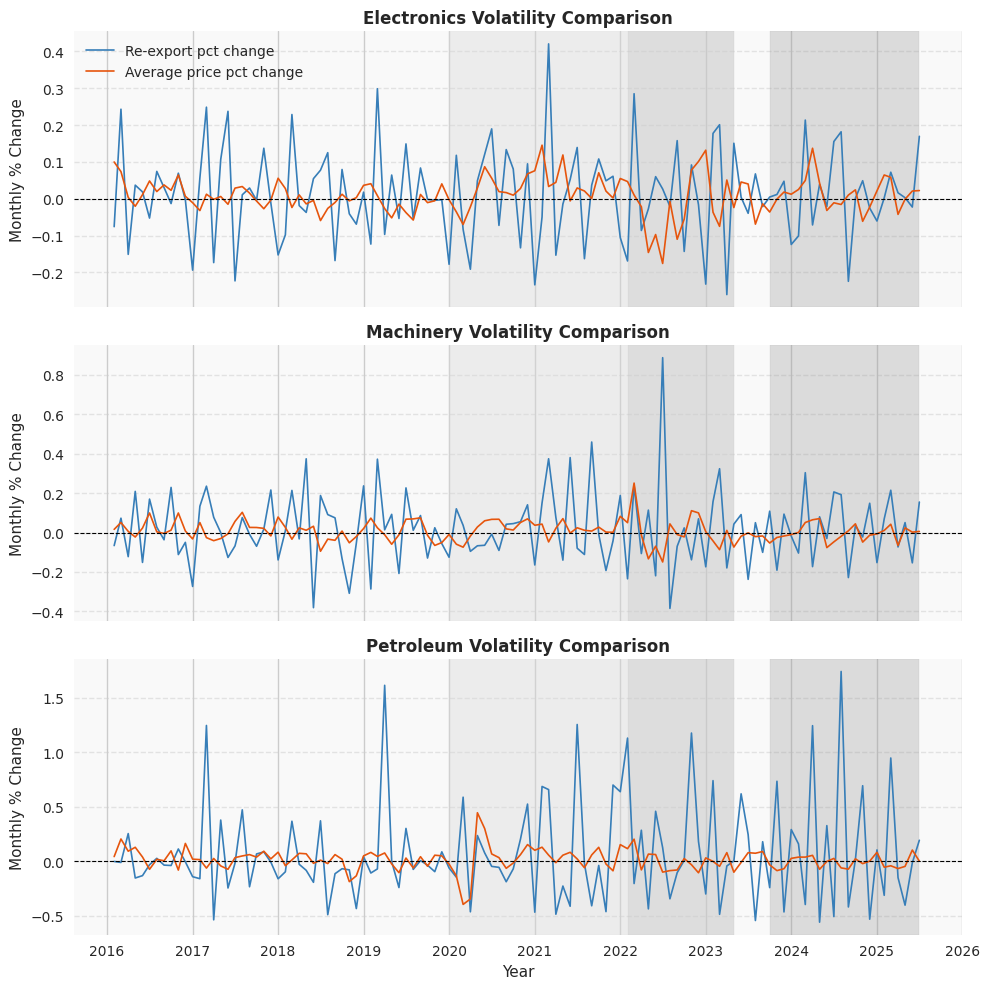

In [ ]:
sns.set_style("whitegrid")
plt.rcParams["axes.facecolor"] = "#f9f9f9"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

categories = ['Electronics', 'Machinery', 'Petroleum']

fig, axes = plt.subplots(len(categories), 1, figsize=(10, 10), sharex=True)

for i, cat in enumerate(categories):
    data = sector_monthly[sector_monthly['Category'] == cat].copy()
    data = data.sort_values('Month')
    data['Month_dt'] = data['Month'].dt.to_timestamp()  # convert to datetime for smooth x-axis

    # Plot lines
    axes[i].plot(data['Month_dt'], data['ReExportValue_pct_change'],
                 color='#377eb8', label='Re-export pct change', lw=1.2)
    axes[i].plot(data['Month_dt'], data['AveragePrice_pct_change'],
                 color='#e6550d', label='Average price pct change', lw=1.2)

    # Highlight disruption periods
    disruptions = [
        ('COVID-19', '2020-01', '2023-05', '#d9d9d9', 0.4),
        ('Russia-Ukraine', '2022-02', '2023-05', '#bdbdbd', 0.3),
        ('Red Sea', '2023-10', data['Month_dt'].max().strftime('%Y-%m'), '#969696', 0.3)
    ]
    for name, start, end, color, alpha in disruptions:
        axes[i].axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=alpha)

    # Formatting
    axes[i].axhline(0, color='black', lw=0.8, linestyle='--')
    axes[i].set_title(f'{cat} Volatility Comparison', fontsize=12, weight='bold')
    axes[i].set_ylabel('Monthly % Change')
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    if i == 0:
        axes[i].legend(loc='upper left', frameon=False)

# Shared X-axis: show one tick per year
axes[-1].set_xlabel('Year')
axes[-1].xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))
axes[-1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.xticks(pd.date_range(start='2016-01-01', end='2026-01-01', freq='YS'), rotation=0)
plt.tight_layout()
plt.show()


**Note:** Not all visualisation have been used in the article, these were mainly created for presentation and for the ease of audience, however in article, we feared it might overwhelm the auidence, hence we cut a few graphs.

**Thank you!!**